# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [36]:
import traceback
import numpy as np
import torch
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import WhisperForConditionalGeneration, WhisperProcessor

from utils import audio, causal

# Load Models

In [4]:
try:
    del clean_model
    del corrupted_model
    print("Models deleted!")
except:
    pass

In [5]:
MODEL_NAME = "tiny.en"

clean_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
corrupted_model = WhisperForConditionalGeneration.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True).cuda()
processor = WhisperProcessor.from_pretrained(f"openai/whisper-{MODEL_NAME}", local_files_only=True)
eos_id = processor.tokenizer.eos_token_id

clean_model.eval()
corrupted_model.eval()

print("Done")

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Done


# Load Data

In [6]:
tedlium_path = "../tedlium"
path = f"{tedlium_path}/test.hf"

In [7]:
SELECT = 100

SEED = 1

data = load_from_disk(path).with_format("torch").shuffle(seed=SEED).select(range(SELECT))

# Register Hooks

In [8]:
activations = {}
debug_activations = {}
hooks = []
temp_hooks = []
activation_count = [0] # global

# Inference

In [9]:
def infer_with_probs(audio, model, processor):
    inputs = processor(audio, return_tensors="pt", sampling_rate=16_000)
    input_features = inputs.input_features.to(model.device)
    
    res = model.generate(input_features, return_dict_in_generate=True, output_scores=True)
    eos_probs = torch.tensor([torch.nn.Softmax(dim=0)(s.squeeze())[eos_id] for s in res["scores"]]) # get eos id for each token
    
    decoded = processor.decode(res.sequences.squeeze(), skip_special_tokens=True)
    return decoded, res, eos_probs

# Establish Clean Hooks

In [26]:
causal.reset(activations, debug_activations, hooks, temp_hooks)

In [27]:
causal.register_all_decoder_blocks(clean_model, causal.clean_hook, activations, hooks)

In [28]:
example = data[20]
wave = example["audio"]
example["text"]

'and some fish meals and then he said chicken pellets'

In [29]:
decoded, res, eos_probs = infer_with_probs(wave, clean_model, processor)
decoded

' and some fish meals and then he said chicken pellets.'

In [30]:
clean_probs = eos_probs.unsqueeze(1).repeat(1, 4) # to be used in finding effect

In [31]:
assert activations, "Activations is empty! Reverify"

# Corrupt Model and Run

In [32]:
# Verify model is sane before inserting hook
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd, p

(' and some fish meals and then he said chicken pellets.',
 tensor([0.0000e+00, 4.2728e-05, 3.6651e-06, 2.8615e-06, 2.3279e-04, 7.3043e-05,
         1.1265e-04, 1.8888e-05, 1.1879e-04, 4.4060e-04, 1.6771e-01, 9.9249e-01]))

In [33]:
embed_hook = causal.register_embedding_hook(corrupted_model, causal.corrupt_embed_hook, hooks, alpha=3)

In [34]:
dd, rr, p = infer_with_probs(wave, corrupted_model, processor)
dd

','

# Restore Layer

In [38]:
results = []
temp_holder = []

results_total = torch.zeros(1)
try:
    for token in tqdm.tqdm(range(len(activations[0])), desc="Tokens", leave=True):
        blocks = []
        for block in range(4):
            correction_hook = causal.register_at_decoder_block(corrupted_model, causal.correction_hook, block, temp_holder, block, token, activations)
            _, _, eos_prob = infer_with_probs(wave, corrupted_model, processor)
            correction_hook.remove()
            blocks.append(eos_prob[1])
        results.append(torch.stack(blocks))
        results_total += torch.stack(results)
except Exception as e:
    correction_hook.remove()
    traceback.print_exc()
finally:
    temp_holder.clear()
    del temp_holder

Tokens:  25%|██▌       | 3/12 [00:07<00:22,  2.56s/it]


KeyboardInterrupt: 

In [23]:
results_stacked = torch.stack(results)

In [24]:
results_stacked.shape

torch.Size([12, 4])

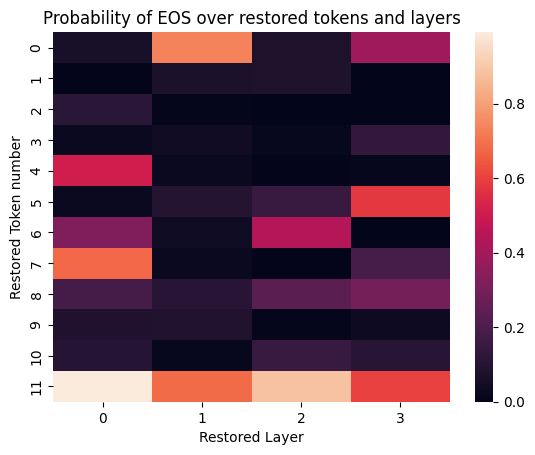

In [25]:
fig, ax = plt.subplots()
ax = sns.heatmap(torch.abs(results_stacked - clean_probs), ax=ax)
ax.set_xlabel("Restored Layer")
ax.set_ylabel("Restored Token number")
ax.set_title("Probability of EOS over restored tokens and layers")
plt.show()